In [120]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Download and Load the Dataset

In [103]:
df = pd.read_csv('https://raw.githubusercontent.com/Ardeshir-Shon/dataMiningLabTutorial/main/kzThiner.csv')

# Data Exploration

In [104]:
df.head()

,event_time,order_id,product_id,category_id,category_code,brand,price,user_id
0,2020-04-24 11:50:39 UTC,2294359932054536986,1515966223509089906,2.268105e+18,electronics.tablet,samsung,162.01,1.515916e+18
1,2020-04-24 11:50:39 UTC,2294359932054536986,1515966223509089906,2.268105e+18,electronics.tablet,samsung,162.01,1.515916e+18
2,2020-04-24 14:37:43 UTC,2294444024058086220,2273948319057183658,2.268105e+18,electronics.audio.headphone,huawei,77.52,1.515916e+18
3,2020-04-24 14:37:43 UTC,2294444024058086220,2273948319057183658,2.268105e+18,electronics.audio.headphone,huawei,77.52,1.515916e+18
4,2020-04-24 19:16:21 UTC,2294584263154074236,2273948316817424439,2.268105e+18,NaN,karcher,217.57,1.515916e+18


In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154004 entries, 0 to 154003
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   event_time     154004 non-null  object 
 1   order_id       154004 non-null  int64  
 2   product_id     154004 non-null  int64  
 3   category_id    127711 non-null  float64
 4   category_code  116700 non-null  object 
 5   brand          122534 non-null  object 
 6   price          127711 non-null  float64
 7   user_id        43660 non-null   float64
dtypes: float64(3), int64(2), object(3)
memory usage: 9.4+ MB


In [106]:
df.describe()

,order_id,product_id,category_id,price,user_id
count,1.540040e+05,1.540040e+05,1.277110e+05,127711.000000,4.366000e+04
mean,2.342330e+18,1.678632e+18,2.273921e+18,140.244452,1.515916e+18
std,1.329211e+16,3.114881e+17,2.374737e+16,234.397863,1.564543e+07
min,2.294360e+18,1.515966e+18,2.268105e+18,0.000000,1.515916e+18
25%,2.346523e+18,1.515966e+18,2.268105e+18,13.870000,1.515916e+18
50%,2.348721e+18,1.515966e+18,2.268105e+18,50.900000,1.515916e+18
75%,2.348769e+18,1.515966e+18,2.268105e+18,162.010000,1.515916e+18
max,2.348772e+18,2.344948e+18,2.374499e+18,18328.680000,1.515916e+18


# Preprocessing

In [107]:
df.isna().sum()

event_time            0
order_id              0
product_id            0
category_id       26293
category_code     37304
brand             31470
price             26293
user_id          110344
dtype: int64

In [108]:
df['event_time'] = pd.to_datetime(df['event_time'])

In [109]:
missing_attributes = ['category_id', 'category_code', 'brand', 'price', 'user_id']

missing_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
])

column_transformer = ColumnTransformer([
    ('missing', missing_pipeline, missing_attributes),
], remainder='passthrough')

In [110]:
transformed_data = column_transformer.fit_transform(df)
transformed_df = pd.DataFrame(transformed_data, columns=column_transformer.get_feature_names_out())

transformed_df.head()

,missing__category_id,missing__category_code,missing__brand,missing__price,missing__user_id,remainder__event_time,remainder__order_id,remainder__product_id
0,2268105426648171008.0,electronics.tablet,samsung,162.01,1515915625441993984.0,2020-04-24 11:50:39+00:00,2294359932054536986,1515966223509089906
1,2268105426648171008.0,electronics.tablet,samsung,162.01,1515915625441993984.0,2020-04-24 11:50:39+00:00,2294359932054536986,1515966223509089906
2,2268105430162997760.0,electronics.audio.headphone,huawei,77.52,1515915625447879424.0,2020-04-24 14:37:43+00:00,2294444024058086220,2273948319057183658
3,2268105430162997760.0,electronics.audio.headphone,huawei,77.52,1515915625447879424.0,2020-04-24 14:37:43+00:00,2294444024058086220,2273948319057183658
4,2268105471367840000.0,electronics.smartphone,karcher,217.57,1515915625443148032.0,2020-04-24 19:16:21+00:00,2294584263154074236,2273948316817424439


# Feature Engineering for RFM

In [118]:
# Calculate the number of days between a customers first and last order
transformed_df['recency'] = (transformed_df.groupby('missing__user_id')['remainder__event_time'].transform('max') - transformed_df.groupby('missing__user_id')['remainder__event_time'].transform('min')).dt.days

# Calculate the number of purchases a customer has made
transformed_df['frequency'] = transformed_df.groupby('missing__user_id')['remainder__event_time'].transform('count')

# Calculate the total amount of money spent by a customer
transformed_df['monetary'] = transformed_df.groupby('missing__user_id')['missing__price'].transform('sum')

transformed_df.head()

,missing__category_id,missing__category_code,missing__brand,missing__price,missing__user_id,remainder__event_time,remainder__order_id,remainder__product_id,recency,frequency,monetary
0,2268105426648171008.0,electronics.tablet,samsung,162.01,1515915625441993984.0,2020-04-24 11:50:39+00:00,2294359932054536986,1515966223509089906,0,2,324.02
1,2268105426648171008.0,electronics.tablet,samsung,162.01,1515915625441993984.0,2020-04-24 11:50:39+00:00,2294359932054536986,1515966223509089906,0,2,324.02
2,2268105430162997760.0,electronics.audio.headphone,huawei,77.52,1515915625447879424.0,2020-04-24 14:37:43+00:00,2294444024058086220,2273948319057183658,4,4,436.24
3,2268105430162997760.0,electronics.audio.headphone,huawei,77.52,1515915625447879424.0,2020-04-24 14:37:43+00:00,2294444024058086220,2273948319057183658,4,4,436.24
4,2268105471367840000.0,electronics.smartphone,karcher,217.57,1515915625443148032.0,2020-04-24 19:16:21+00:00,2294584263154074236,2273948316817424439,30,3,337.89


# Implement K-means

In [125]:
# Apply K-Means clustering to the RFM data
X = transformed_df[['recency', 'frequency', 'monetary']].values
kmeans = KMeans(n_clusters=5, n_init=10, random_state=42).fit(X)

# Elbow Method

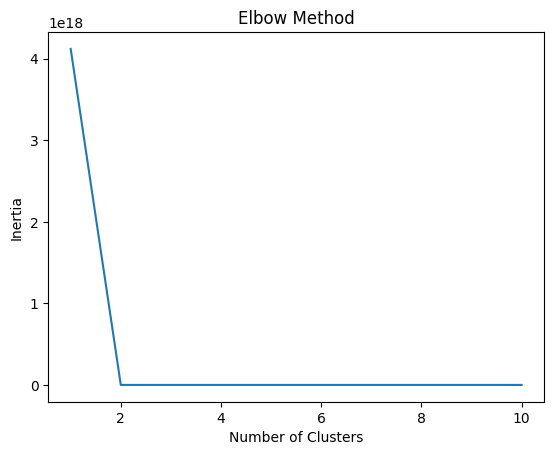

In [126]:
# Apply the elbow method to find the optimal number of clusters
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42).fit(X)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()